# RTML Lab 3: ResNet, SeNet and GradCam

NAME = "Todsavad Tangtortan"
ID = "123012"

## Lab report

As usual, write up an introduction, methods, results, and conclusion based on your work as a Jupyter notebook, export to PDF,
and submit in the Google Classroom before next week's lab.

Interestingly, we can see that the additional parameters accelerate learning of the training set without
causing any degredation on the validation set and in fact improving validation set performance early
on.

## Independent exercises (Please modify)

1. Get your Docker container running on the GPU server and get VSCode talking to your Docker container as in previous labs.
2. Set up the ResNet and ResSENet classes with supporting functions using a good structure (one class per file) as in Lab 02.
   Fix any warnings pylint finds in our sample code. :-)

In [1]:
#ResNet Model
import torch.nn as nn
import torch.nn.functional as F

# %%
class BasicBlock(nn.Module):
    '''
    BasicBlock: Simple residual block with two conv layers
    '''
    EXPANSION = 1
    def __init__(self, in_planes, out_planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.shortcut = nn.Sequential()
        # If output size is not equal to input size, reshape it with 1x1 convolution
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# %%
class BottleneckBlock(nn.Module):
    '''
    BottleneckBlock: More powerful residual block with three convs, used for Resnet50 and up
    '''
    EXPANSION = 4
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.EXPANSION * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.EXPANSION * planes)

        self.shortcut = nn.Sequential()
        # If the output size is not equal to input size, reshape it with 1x1 convolution
        if stride != 1 or in_planes != self.EXPANSION * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.EXPANSION * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.EXPANSION * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# %%
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding = 1) # added maxpool layer to math the paper

        # Residual blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # FC layer = 1 layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.EXPANSION, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.EXPANSION
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = self.maxpool(out)
        out = F.relu(self.bn1(self.conv1(x)))
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# %%
def ResNet18(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with two sets of two convolutions each: 2*2 + 2*2 + 2*2 + 2*2 = 16 conv layers
    last FC layer: 1
    Total layers: 1+16+1 = 18
    '''
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)


def ResNet34(num_classes):
    '''
    First conv layer: 1
    4 residual blocks with [3, 4, 6, 3] sets of two convolutions each: 3*2 + 4*2 + 6*2 + 3*2 = 32
    last FC layer: 1
    Total layers: 1+32+1 = 34
    '''
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)


def ResNet50(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with [3, 4, 6, 3] sets of three convolutions each: 3*3 + 4*3 + 6*3 + 3*3 = 48
    last FC layer: 1
    Total layers: 1+48+1 = 50
    '''
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes)


def ResNet101(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with [3, 4, 23, 3] sets of three convolutions each: 3*3 + 4*3 + 23*3 + 3*3 = 99
    last FC layer: 1
    Total layers: 1+99+1 = 101
    '''
    return ResNet(BottleneckBlock, [3, 4, 23, 3], num_classes)


def ResNet152(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with [3, 8, 36, 3] sets of three convolutions each: 3*3 + 8*3 + 36*3 + 3*3 = 150
    last FC layer: 1
    Total layers: 1+150+1 = 152
    '''
    return ResNet(BottleneckBlock, [3, 8, 36, 3], num_classes)

### For ResNet Model, there are 2 points which edit to match with the architecture described in the paper.
- Change the initial convolution kernel size to 7
- Add MaxPooling layer after BatchNorm2d

In [ ]:
#ResSENet Model
import torch.nn as nn
from resnet_model import ResNet
import torch.nn.functional as F

class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ResidualSEBasicBlock(nn.Module):
    '''
    ResidualSEBasicBlock: Standard two-convolution residual block with an SE Module between the
                          second convolution and the identity addition
    '''
    EXPANSION = 1

    def __init__(self, in_planes, out_planes, stride=1, reduction=16):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.se = SELayer(out_planes, reduction)

        self.shortcut = nn.Sequential()
        # If output size is not equal to input size, reshape it with a 1x1 conv
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.EXPANSION * out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)              # se net add here
        out += self.shortcut(x)         # shortcut just plus it!!!
        out = F.relu(out)
        return out


def ResSENet18(num_classes = 10):
    return ResNet(ResidualSEBasicBlock, [2, 2, 2, 2], num_classes)


3. Switch to 256x256 scaling and 224x224 cropping for CIFAR as standardized for ImageNet. Modify the implementation to use
   the same convolutions (e.g., initial 7x7) and other layer settings found in the ResNet paper. Find competitive hyperparameters for
   ResNet18 and ResSENet18 you can and report your results.

In [ ]:
# Allow augmentation transform for training set, no augementation for val/test set

'''
train_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

eval_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
'''

- For data augmentation, chaning to 256x256 scaling and 224x224 cropping for CIFAR which were the standard augmentation for ImageNet
- For the training set, using RandomCrop and RandomHorizontalFlip
- For the validation and test set, using only CenterCrop.

In [ ]:
#Traning ResNet SGD learning rate : 0.01, monemtum : 0.9
'''
Epoch 24/24
----------
train Loss: 0.2126 Acc: 0.9251
Epoch time taken:  173.42196822166443
val Loss: 0.3928 Acc: 0.8750
Epoch time taken:  190.02183413505554

Training complete in 79m 32s
Best val Acc: 0.875000
'''
#Testing ResNet SGD learning rate : 0.01, monemtum : 0.9
'''
test Loss: 0.3880 Acc: 0.8797
'''

In [ ]:
#Traning ResNet SGD learning rate : 0.01, monemtum : 0.9, weight_decay : 0.0001
'''
Epoch 24/24
----------
train Loss: 0.1829 Acc: 0.9366
Epoch time taken:  181.1041021347046
val Loss: 0.3871 Acc: 0.8755
Epoch time taken:  198.00470638275146

Training complete in 81m 29s
Best val Acc: 0.888900
'''
#Testing ResNet SGD learning rate : 0.01, monemtum : 0.9, weight_decay : 0.0001
'''
test Loss: 0.3754 Acc: 0.8812
'''

In [ ]:
#Traning ResNet Adam learning rate 0.01
'''
Epoch 24/24
----------
train Loss: 0.1957 Acc: 0.9325
Epoch time taken:  176.92339634895325
val Loss: 0.4305 Acc: 0.8660
Epoch time taken:  193.23867511749268

Training complete in 81m 18s
Best val Acc: 0.872500
'''
#Testing ResNet Adam learning rate 0.01
'''
test Loss: 0.4264 Acc: 0.8676
'''

In [ ]:
#Traning ResNet Adam learning rate : 0.01, weight_decay : 0.0005
'''
Epoch 24/24
----------
train Loss: 1.0032 Acc: 0.9251
Epoch time taken:  176.92339634895325
val Loss: 0.9674 Acc: 0.6547
Epoch time taken:  193.23867511749268

Training complete in 80m 10s
Best val Acc: 0.6547
'''
#Testing ResNet Adam learning rrate : 0.01, weight_decay : 0.0005
'''
test Loss: 0.9832 Acc: 0.6628
'''

In [ ]:
#Traning ResSENet SGD learning rate : 0.01, monemtum : 0.9
'''
train Loss: 0.1222 Acc: 0.9571
Epoch time taken:  199.08523273468018
val Loss: 0.3332 Acc: 0.9021
Epoch time taken:  219.11097955703735

Training complete in 89m 34s
Best val Acc: 0.902100
'''
#Testing ResSENet SGD learning rate : 0.01, monemtum : 0.9
'''
test Loss: 0.3506 Acc: 0.8953
'''

In [ ]:
#Traning ResSENet SGD learning rate : 0.01, monemtum : 0.9, weight_decay : 0.0001
'''
Epoch 24/24
----------
train Loss: 0.3188 Acc: 0.8931
Epoch time taken:  201.43707418441772
val Loss: 0.4106 Acc: 0.8578
Epoch time taken:  221.6597032546997

Training complete in 105m 46s
Best val Acc: 0.874200
'''
#Testing ResSENet SGD learning rate : 0.01, monemtum : 0.9, weight_decay : 0.0001
'''
test Loss: 0.3875 Acc: 0.8729
'''

In [ ]:
#Traning ResSENet Adam learning rate : 0.01
'''
Epoch 24/24
----------
train Loss: 0.2641 Acc: 0.9076
Epoch time taken:  194.07701754570007
val Loss: 0.4524 Acc: 0.8606
Epoch time taken:  211.7615306377411

Training complete in 88m 19s
Best val Acc: 0.861500
'''
#Testing ResSENet Adam learning rate : 0.01
'''
test Loss: 0.4540 Acc: 0.8554
'''

In [ ]:
#Traning ResSENet Adam learning rate : 0.01, weight_decay : 0.0001
'''
Epoch 24/24
----------
train Loss: 1.3009 Acc: 0.5383
Epoch time taken:  196.39878392219543
val Loss: 1.7016 Acc: 0.4149
Epoch time taken:  214.19287991523743

Training complete in 88m 60s
Best val Acc: 0.532500
'''
#Testing ResSENet Adam learning rate : 0.01, weight_decay : 0.0001
'''
test Loss: 1.2968 Acc: 0.5280
'''

| Model    | Optimizer | Weight Decay | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc | Time Taken |
|----------|-----------|--------------|------------|-----------|----------|---------|-----------|----------|------------|
| ResNet   | SGD       |              | 0.2126     | 92.51 %   | 0.3928   | 87.50 % | 0.388     | 87.97 %  | 79m 32s    |
| ResNet   | SGD       | &check;      | 0.1826     | 93.66 %   | 0.3871   | 87.55 % | 0.3754    | 88.12 %  | 81m 29s    |
| ResNet   | Adam      |              | 0.1957     | 93.25 %   | 0.4305   | 87.25 % | 0.4264    | 86.76 %  | 81m 18s    |
| ResNet   | Adam      | &check;      | 1.0032     | 64.92 %   | 0.9674   | 65.47 % | 0.9832    | 66.28 %  | 80m 10s    |
| ResSENet | SGD       |              | 0.1222     | 95.71 %   | 0.3332   | 90.21 % | 0.3506    | 89.53 %  | 89m 34s    |
| ResSENet | SGD       | &check;      | 0.3188     | 89.31 %   | 0.4106   | 8578    | 0.3875    | 87.29 %  | 105m 46s   |
| ResSENet | Adam      |              | 0.2641     | 90.76 %   | 0.4525   | 86.06 % | 0.4540    | 85.54 %  | 88m 19s    |
| ResSENet | Adam      | &check;      | 1.3009     | 53.83 %   | 1.7016   | 53.25 % | 1.2968    | 52.80 %  | 88m 60s    |

In [7]:
import matplotlib.pyplot as plt

def plot_data(val_acc_history, loss_acc_history, val_acc_history2, loss_acc_history2):
    plt.plot(loss_acc_history, label = 'ResNet18')
    plt.plot(loss_acc_history2, label = 'ResSENet18')
    plt.title('Training loss over time')
    plt.legend()
    plt.show()
    plt.plot(val_acc_history, label = 'ResNet18')
    plt.plot(val_acc_history2, label = 'ResSENet18')
    plt.title('Validation accuracy over time')
    plt.legend()
    plt.show()

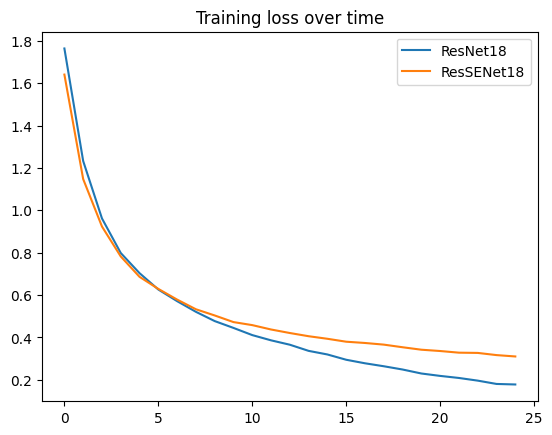

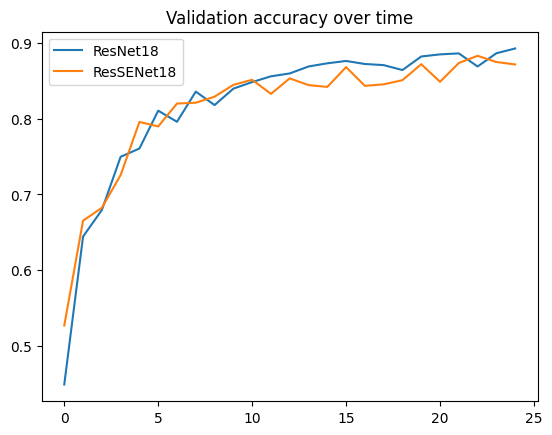

In [8]:
import numpy as np

accResNet = np.load('./plot/resnet18SGD_WD_val_acc_history.npy', allow_pickle=True)
lossResNet = np.load('./plot/resnet18SGD_WD_loss_history.npy', allow_pickle=True)

accResSENet = np.load('./plot/resSENet18SGD_WD_val_acc_history.npy', allow_pickle=True)
lossResSENet = np.load('./plot/resSENet18SGD_WD_loss_history.npy', allow_pickle=True)

plot_data(accResNet, lossResNet, accResSENet, lossResSENet)

4. As practice in transfer learning for very small datasets, take your best ResSENet18 from the exercise above and fine tune it
   on the [Chihuahua vs. Muffins Challenge](https://www.topbots.com/chihuahua-muffin-searching-best-computer-vision-api/?amp).
   You only have 16 examples from each category, so to get a reasonable validation accuracy estimate,
   use 8-fold cross validation for this experiment. In particular,
   fine tune your model 8 different times, holding out two examples from each category as the validation set each time, report
   the average accuracy as the expected accuracy of your model, then train a final fine-tuned
   model on all of the data with the hyperparameters found during cross validation.
   Lastly, test the final model on a few muffin and chihuahua images you find online that are not identical to the examples
   in the meme. Have fun with it!

In [4]:
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader,Subset
import torch
import torch.nn as nn
import torch.optim as optim
# Set device to GPU or CPU

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

train_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = datasets.ImageFolder(root='./chihuahua_muffin/', transform=train_preprocess)
dataloaders = DataLoader(dataset, batch_size = 16) # get all 16 images into 1 batch

In [2]:
import numpy as np

def plot_data(ax,val_acc_history,loss_acc_history,fold):
    ax[0].plot(np.arange(25),np.array(val_acc_history),label = f"val acc model{fold}")
    ax[1].plot(np.arange(25),np.array(loss_acc_history),label = f"val acc model{fold}")
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[1].set_ylabel("Loss")    
    ax[0].set_title(f"Accuracy vs Epochs of model {fold+1}")
    ax[1].set_title(f"Loss vs Epochs of model {fold+1}")
    ax[0].legend()
    ax[1].legend()
    ax[0].grid(True)
    ax[1].grid(True)    

/root/lab03/train_model_chihuahuamuffin.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_acc_history.append(torch.tensor(epoch_acc).detach().cpu())


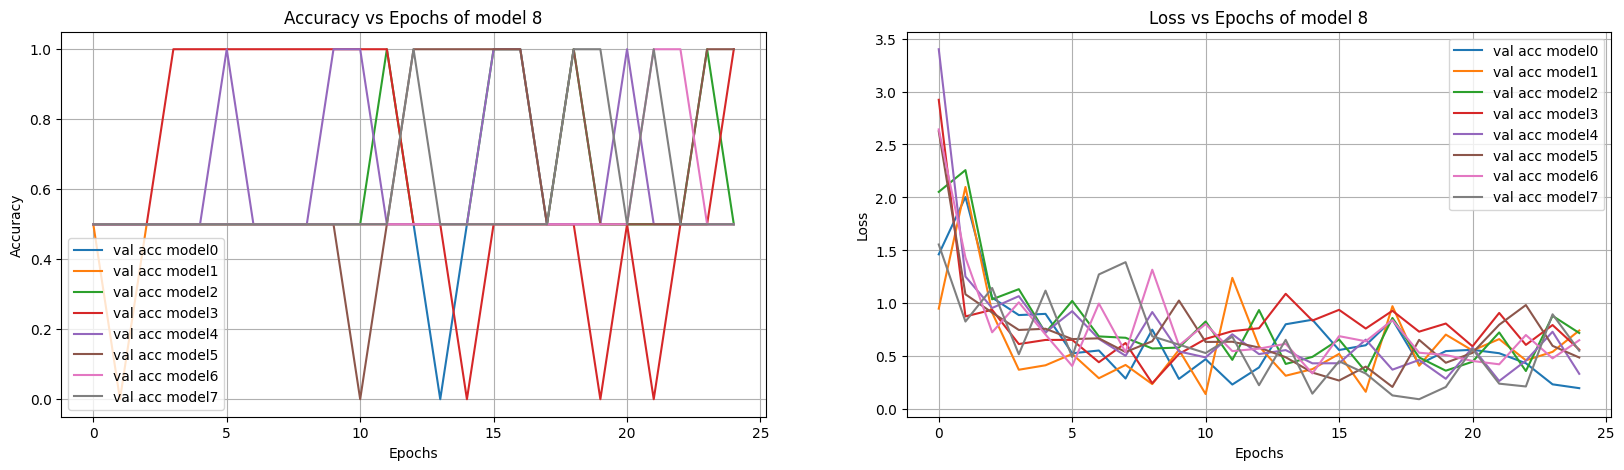

Average accuracy of model: 0.5725


In [3]:
from sklearn.model_selection import StratifiedKFold
from train_model_chihuahuamuffin import train_model
from senet_model import ResSENet18
import numpy as np
import matplotlib.pyplot as plt
folds = 8
skf = StratifiedKFold(n_splits=folds, shuffle=True)
fig,ax = plt.subplots(1,2,sharex=True,figsize=(20,5))

model_acc = 0
for fold, (train_index, val_index) in enumerate(skf.split(dataset, dataset.targets)):
      batch_size = 4
      train = Subset(dataset, train_index)
      val = Subset(dataset, val_index)
      
      train_loader = DataLoader(train, batch_size=batch_size, 
                                                shuffle=True, num_workers=0, 
                                                pin_memory=False)
      val_loader = DataLoader(val, batch_size=batch_size, 
                                                shuffle=True, num_workers=0, 
                                                pin_memory=False)

      dataloaders = {'train': train_loader, 'val': val_loader}
      
      #There are only 2 classes
      model = ResSENet18()
      model.linear = nn.Linear(512,2)
      model.eval()
      model.to(device)

      dataloaders = {'train': train_loader, 'val': val_loader}
      criterion = nn.CrossEntropyLoss().to(device)
      optimizer =  optim.Adam(model.parameters(), lr = 0.005 + 0.005*2)

      bestmodel, val_acc_history, loss_acc_history = train_model(model, dataloaders, criterion, optimizer, device, 25, 'train_se_chimuffin')
 
      plot_data(ax,val_acc_history,loss_acc_history,fold)
      model_acc = model_acc + sum(val_acc_history)/len(val_acc_history)

plt.show()
print(f'Average accuracy of model: {model_acc/8}')

In [7]:
from senet_model import ResSENet18
import torch.nn as nn
# Set device to GPU or CPU

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

model = ResSENet18()
model.linear = nn.Linear(512,2)
model.eval()
model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer =  optim.Adam(model.parameters(), lr = 0.005 + 0.005*2)

In [9]:
from test_model import test_model

model.load_state_dict(torch.load('train_se_chimuffin.pth'))

test_dataset = datasets.ImageFolder(root='./test_chihuahua_muffin/', transform=test_preprocess) # used the same transformation the resize and crop the images

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 8, shuffle=True) # load all 8 images into 1 batch
test_dataloaders = { 'test': test_dataloader }

test_acc, test_loss = test_model(model, test_dataloaders, criterion, device)

test Loss: 0.9929 Acc: 0.7500


5. Find 20 different images that have multiple classes of CIFAR dataset classes. Show the result in Grad-CAM using your trained model as above.

In [1]:
from resnet_model import ResNet18
import torch
# Set device to GPU or CPU

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

resnet = ResNet18().to(device)
resnet.load_state_dict(torch.load('resnet18SGD_WD_bestsofar.pth'))

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

In [2]:
import os
folder = './PASCALVOC2012/'
output = './CamImage_ResNet/'
rawImage = os.listdir(folder)
from GradCAM import GradCam
for i in range(20):
    GradCam(rawImage[i], folder, resnet, device, output)

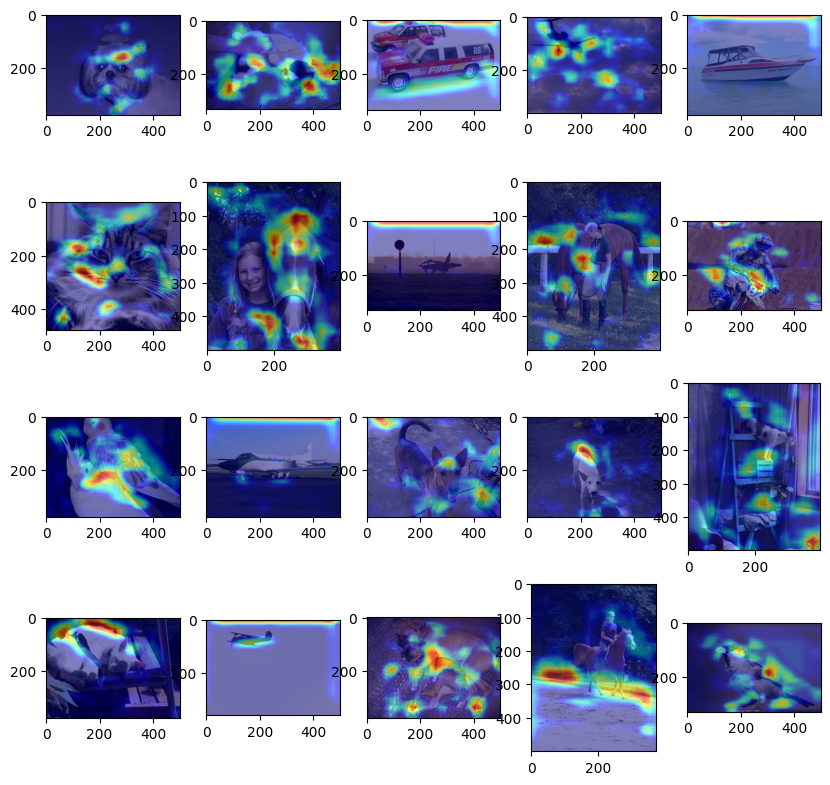

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

cam_list = os.listdir(output)
plt.figure(figsize=(10,10))
for i in range(20):
    img = mpimg.imread(output+cam_list[i])
    plt.subplot(4,5,i+1)
    plt.imshow(img)
plt.show()

In [4]:
from senet_model import ResSENet18
ressenet = ResSENet18().to(device)
ressenet.load_state_dict(torch.load('resSENet18SGD_WD_bestsofar.pth'))

<All keys matched successfully>

In [5]:
import os
folder = './PASCALVOC2012/'
output = './CamImage_ResSENet/'
rawImage = os.listdir(folder)
from GradCAM import GradCam
for i in range(20):
    GradCam(rawImage[i], folder, ressenet, device, output)

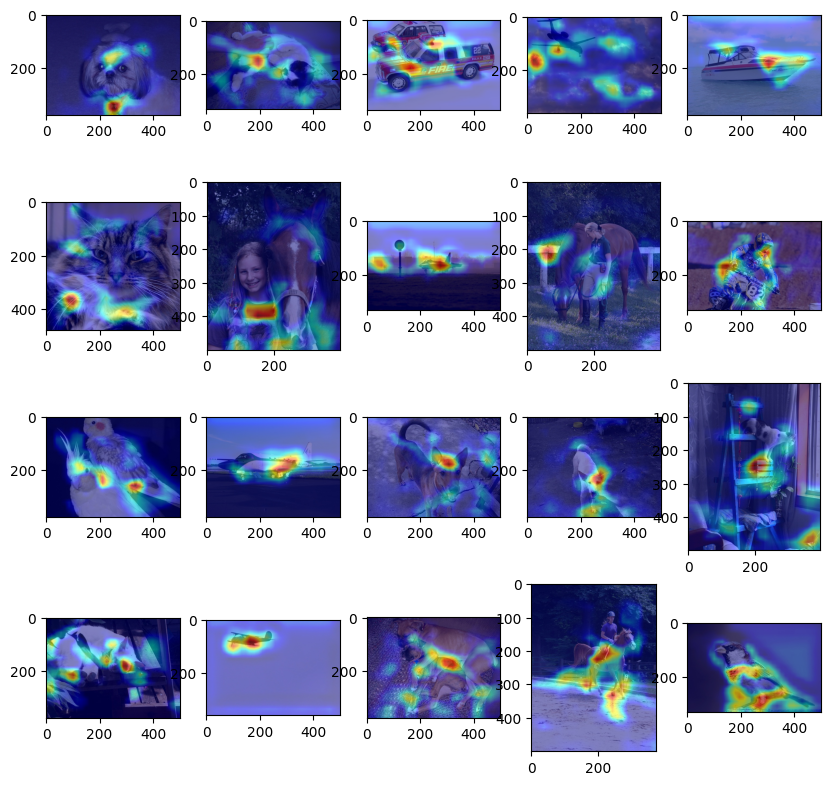

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

cam_list = os.listdir(output)
plt.figure(figsize=(10,10))
for i in range(20):
    img = mpimg.imread(output+cam_list[i])
    plt.subplot(4,5,i+1)
    plt.imshow(img)
plt.show()

In [ ]:
# from IPython.display import display
# from PIL import Image
# display(Image.open("ex_cam.jpg"))

## Conclusion